Justus Tulowiecki

# Object Detection and Tracking

# Literature Review
## Detection Models
### FCOS

The paper can be found at: https://arxiv.org/pdf/1904.01355.pdf


FCOS is a Fully Convolutional One Stage object detection model. When FCOS was first introduced, two-stage detectors were considered state-of-the-art models. However, FCOS showed that a fully convolutional single stage detector can produce very competitive results while being much faster. Additionally, FCOS does not incorporate pre defined anchor boxes or region proposals which drastically reduces parameters and computation time. This also gives FCOS an advantage over other single stage detectors like YOLO v2/v3 in that FCOS is more robust against changes in object size and aspect ratio. To get a better understanding of FCOS, let's briefly look at the model architecture:


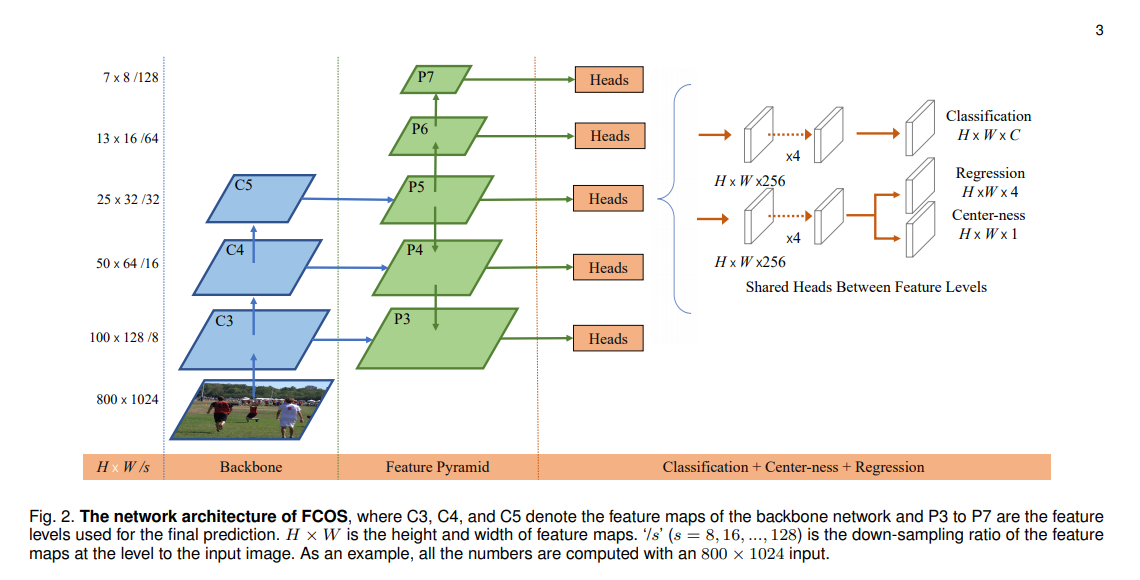


The backbone network is a network that is pre-trained on image net, such as ResNet50 and Mobilenetv2. Let's consider ResNet50 as our backbone. We feed forward an image through the network and store the last three feature maps. These feature maps are then fed into a feature pyramid to aid in detection at different scale. We then attach identical heads to each feature pyramid consisting of two branches--a classification branch and bounding box regression branch. Each branch consists of four 2 $\times$ 2 convolutions (parameters are not shared between the branches). The classification branch outputs a feature map of H $\times$ W $\times$ C where C is the number of classes. Likewise the regression branch outputs feature maps of identical spatial dimensions but two different heads:

1. A regression head with 4 channels representing the distances to the edge of the box from the center 
2. Centerness-head which, as the name implies, is the centerness of the box

Next, we move on to examining how FCOS performs compared to the state-of-the-art. The paper neatly summarizes the results in a chart that compares to current state-of-the-art methods at the time.

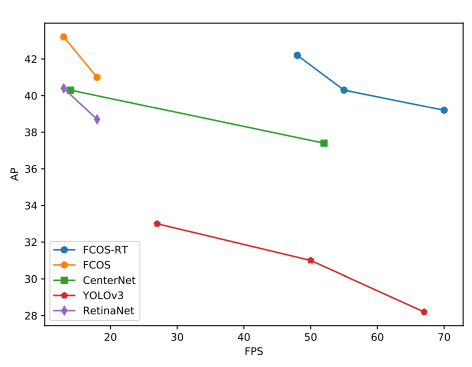

We see that the "original" form of FCOS performs extremely well, in terms of AP but is somewhat slow. To speed up the network they decreased the image size, which is denotes FCOS-RT (RT denoting "Real Time"). FCOS_RT beats YOLO v3 by a hefty margin, with an absolute difference of 10 points more AP while maintaining very high frame rates. With such high frame rates, we can expect a move closer to real time object tracking which has been challenging partly due to the speed and accuracy of object detection models. To summarize we ask: what are the advantages of the new method?
- Reusability with other FCN tasks such as semantic segmentation
- Proposal/Anchor free thus resulting in simpler computation and easier training
- FCOS can be used as region proposal networks in two-stage detectors for better performance
- State of the art performance


## Tracking Models

### Siam Mask

Source: https://arxiv.org/pdf/1812.05050.pdf


Siam Mask aims to perform both object tracking and segmentation in real time using an offline training approach and a single bounding box instantiation. Siam Mask is able to produce rotated bounding in conjunction with the object segmentation. At evaluation time, object tracking is done online and can reach speeds of 55 frames per second. Previous methods have been computationally expensive, and have lacked the ability to track and create a binary segmentation mask for the object specified in the inital frame. To accomplish this task one network is trained on three tasks:

1. Measure similarity between between target object and multiple candidates
2. Bounding Box regression
3. Binary Segmentation (binary labels not required during online segmentation and tracking)

To visualize the network, consider the following figure:

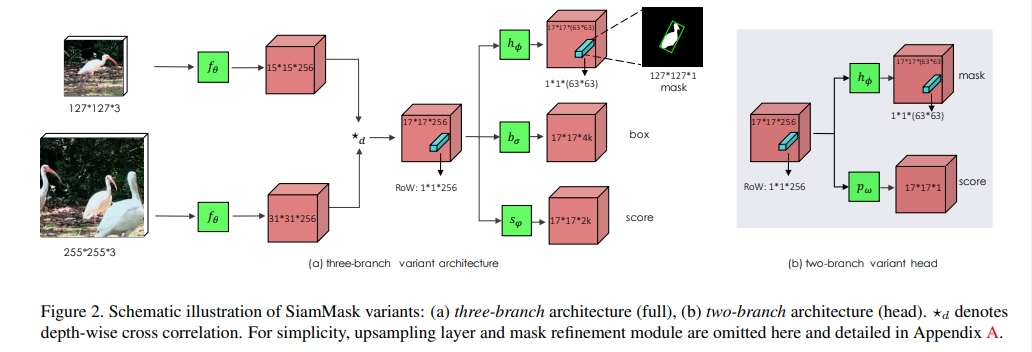

An image explar of 255x255 pixels and a search image of 127x127 pixels is passed into the network. Depthwise-cross correlation is performed to obtain responses of candidate windows (i.e. the spatial elements of the feature maps) which encodes similarity between the images. The result is a 17x17x256 feature map which is fed into the three branches for a binary segmentation mask, bounding box, and a classification score. The backbone network is ResNet-50 up until the final convolution of the 4th stage and the convolutions with stride of 2 are replaced with dilated convolutions to increase the receptive field.

While being relatively fast during online evaluation, we proposed this as a network to attempt object tracking. However, while coding the model and looking at the data required we realized that this model is not friendly to a home setup. For example, the training data spans multiple datasets: Youtube VOS, MS COCO, and the DET dataset. We have included the code we produced for Siam Mask, but for the previous reasons have decided not to continue with its use in our project. We turn our attention to the following algorithm SORT, which is a fast, efficient, and non neural-network approach to object tracking.

### SORT

The algorithm is based off of the paper, "Simple Online and Realtime Tracking" by Alex Bewley, Zongyuan Ge, Lionel Ott, Fabio Ramos and Ben Upcroft. It was published in 2016 and has 624 citations.	

The paper can be found at: https://arxiv.org/pdf/1602.00763.pdf


The first step in object tracking is object detection. The state of each model is represented by $x = [ u , v , s , r , u^1 , v^1 , s^1 ]^T$.  Here, $u$ and $v$ are the horizontal and vertical locations of the center pixel of the target. Next, $s$ and $r$ denote the scale and aspect ratio of the bounding box of the target. The aspect ratio is considered to be constant over time. If a detection is associated with a target, then the Kalman filter solves for the velocity optimally using the detected bounding box. If there is no detection associated with a target, then its prediction is solved for using the linear velocity model. This assumes constant movement, but could be helpful if a target has moved out of frame.

When assigning a new detection to an existing target, the bounding box of the target is estimated by predicting the target's new location in the frame. The assignment cost matrix is computed using the intersection over union distance between each detection and the bounding boxes. There is a minimum intersection over union threshold imposed to reject poor assignments.  The assignment is then solved using the hungarian algorithm. 

Each time an object enters or exits the frame, unique identities for it need to be created or destroyed respectively. If the intersection over union reaches a minimum threshold, then an object begins to be tracked. The velocity of said object is initialized at zero. The covariance of the velocity is set to a large value to incorporate the unknown qualities of the object’s velocity. There is also a period of time in which the new object is scrutinized to see if it is indeed a target, or if it is simply a false positive. If an object has not been tracked for a specified amount of frames, it is terminated. This prevents the number of trackers from unbound growth. In the paper, they set the amount to one frame. This boosts efficiency by limiting the amount of trackers. They also do it because they are primarily concerned with frame to frame tracking. If an object reappears, it will simply be reidentified.

## Misc

### Non-Local Block

Source: https://openaccess.thecvf.com/content_cvpr_2018/papers/Wang_Non-Local_Neural_Networks_CVPR_2018_paper.pdf

Here I am very briefly going to explain one of the modifications we decided to test to our network--the non-local block. In particular, we will examine the gaussian version of the block. The non-local block is as the name implies, it can incorporate global information in a network which is useful as convolutions are only able to capture local information until deeper layers. The visualization of the block is as follows:

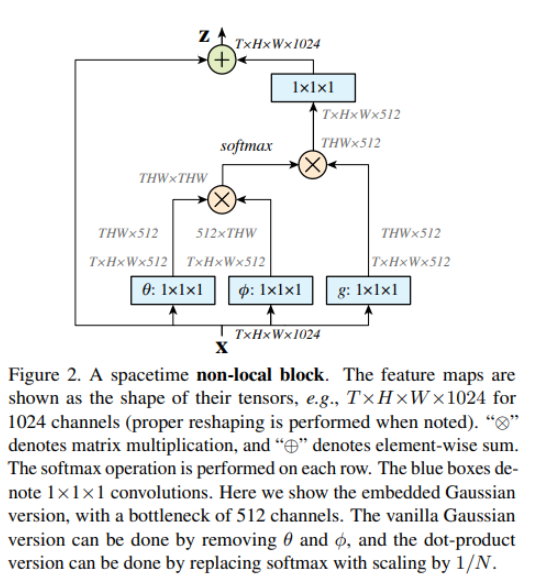

For the gaussian version $\theta$ and $\phi$ are simply the data of dimension HxWx512 (we ignore T here as we will only consider the case of working with images). We reshape the data and take the dot product to obtain the dot-product similarity. This is fed into a softmax to normalize the output. From here, we multiply the output with data that has passed through a 1x1 convolution with 512 output channels. This output passes through a final 1x1 convolution to adjust the output channels to 1024, where it is then added element-wise with a residual connection.

# EDA

In this next section, we will give a brief background on the datasets we will be exploring for object detection.

### MS COCO
Paper and full details located at: https://arxiv.org/pdf/1405.0312.pdf

Here we will perform exploratory data analysis on the popular Common Objects in Context dataset for object detection. First, a brief background on the dataset. COCO was released in 2014 with the goal of solving three problems:
1. Detection non-canonical perspectives of objects, e.g., objects not in center of frame and at a large scale.
2. Contextual reasoning between objects
3. Precise 2D localization of objects

Past datasets often ignored these issues that exist in the real world, where an object may be partially occluded or in the background of an image. The dataset contains multiple tasks: detection, pose estimation, keypoints, image captions, instance segmentation, and panoptic segmentation. For our purposes, the object segmentation/detection has 80 categories to be classified. Below is an example of an image from the dataset.

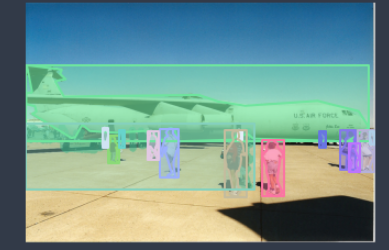
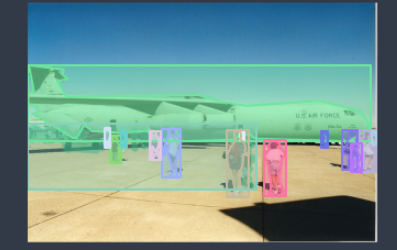

As one might suspect from looking at this image, the classes of objects are highly imbalanced in the dataset. Consider the following plot:

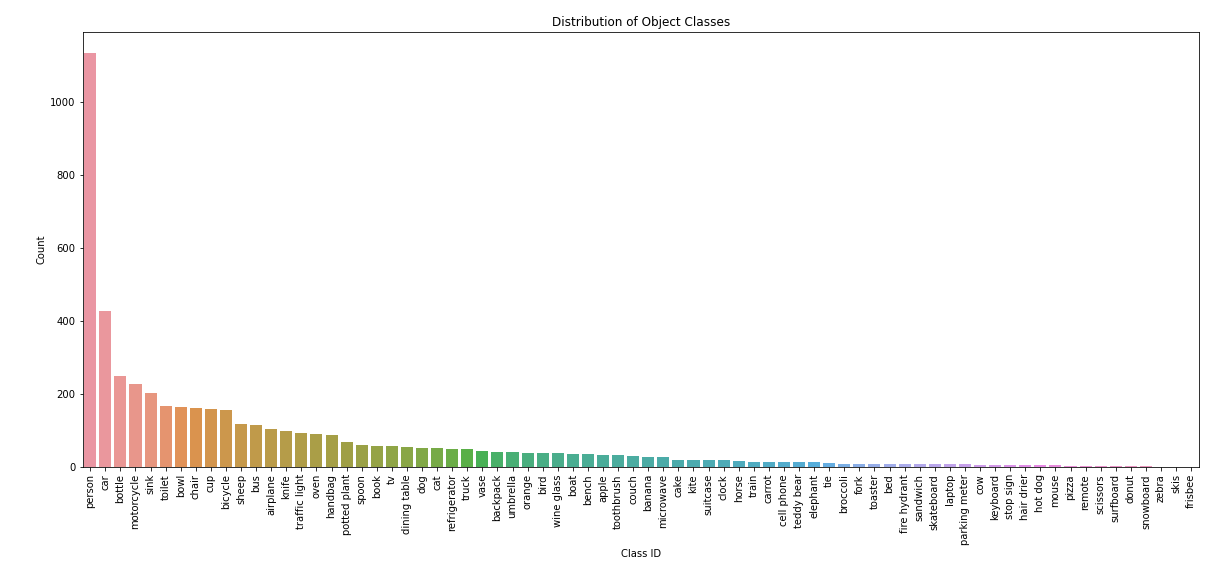
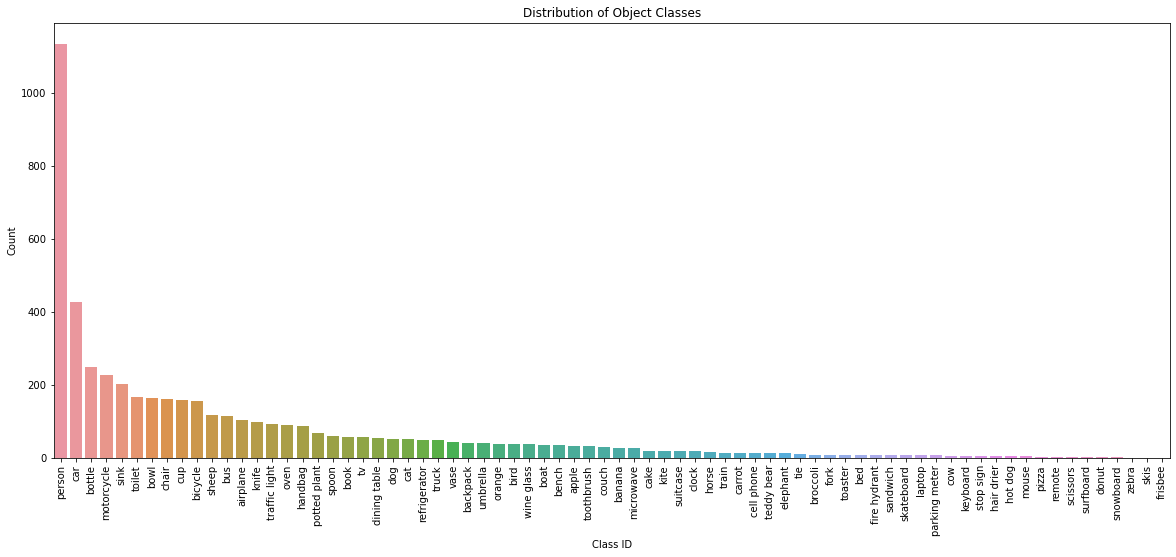

We see that people overwhelmingly make up the majority of the dataset and are twice as frequent than the even the next most frequent object (cars). This could suggest that data augmentation and mining for hard examples can be useful. An object like zebra, which is rare in COCO, could be oversampled with augmentation to make up for the lack of its frequency. 

Another important consideration is the distribution of the size of images. While images are often resized for training, we learned that image/object size can be great importance when training a deep learning model. One of the models used in this project, FCOS, has a parameter that looks for images between size ranges, thus, the size of the images and objects do matter! To analyze image size we generated this plot:

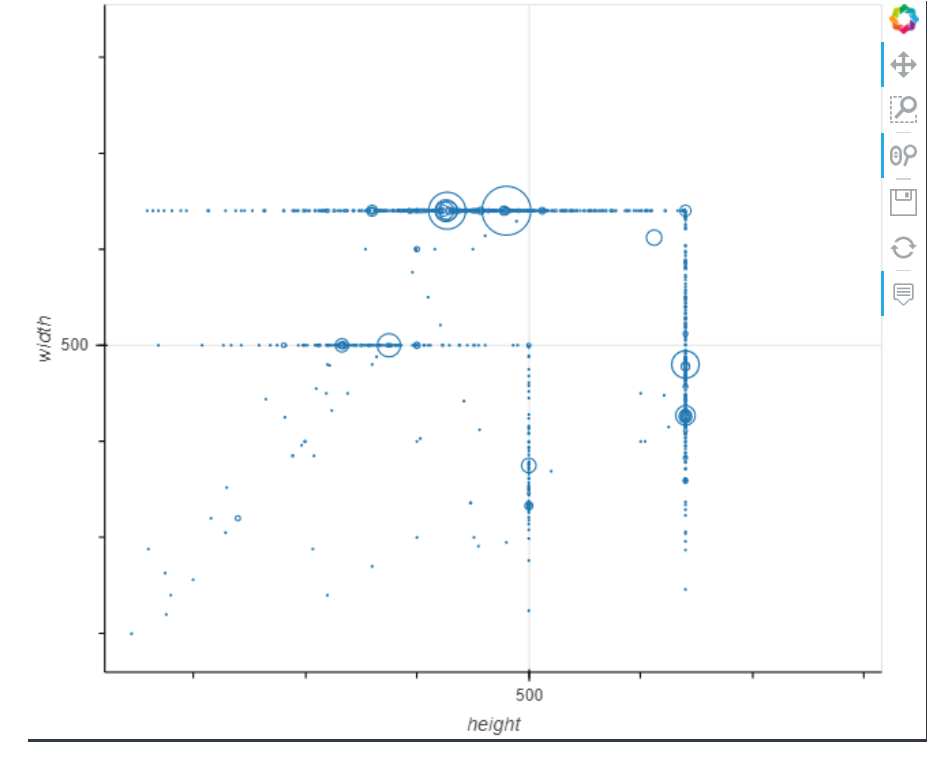
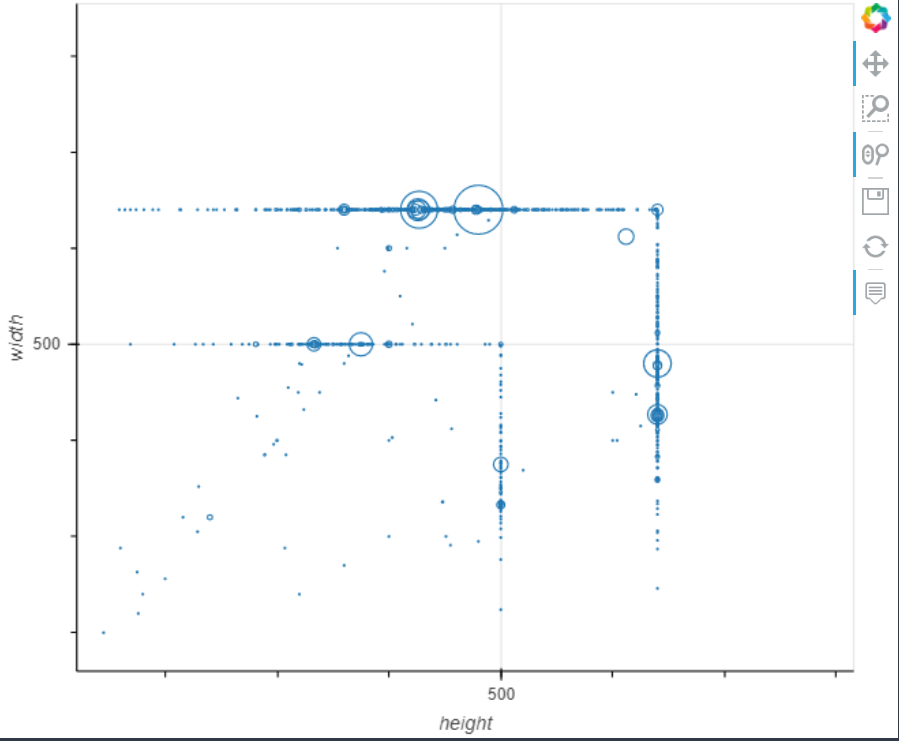

We see that the majority of images fall within two ranges of pixel height and width. There is a distinct pattern of images with a width of 500 or a height of 500 and similarly with height and width of 650

### PASCAL VOC

The paper can be found at: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.157.5766&rep=rep1&type=pdf


We perform a similar analysis for the Pascal VOC dataset. VOC itself is actually quite old, dating back to 2005 and contained only 4 classes, 1578 images, and 2209 annotated objects. The challenge has evolved over the years, and so has the data used. For the 2012 (most recent) version, there are 20 classes with 11,530 images, 27,450 regions of interest and 6,929 segmentations.

Let's start off by looking at an example from the VOC dataset. 

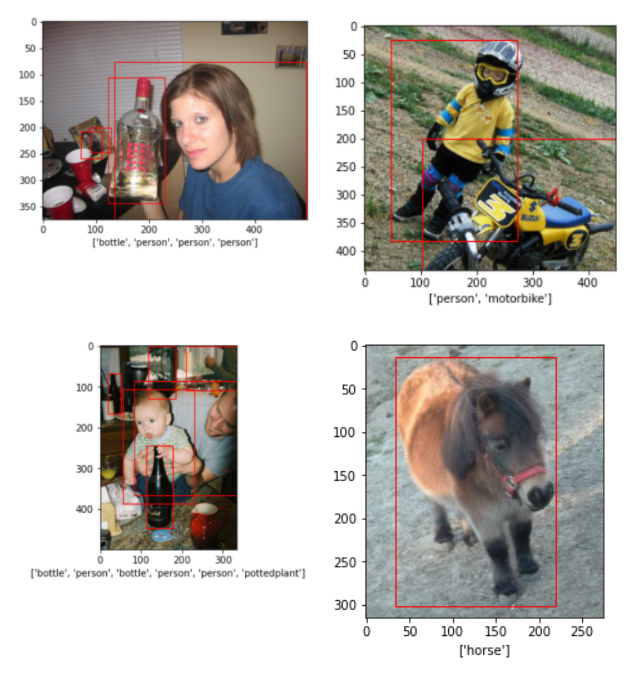

Code to generate these images can be found at /EDA/Plotting/plotting_truth.ipynb

Looking at the distribution of classes below, we see a similarity VOC has with COCO--that is that people are the most common class. Cars are the second most populous class for each dataset. Notice that VOC has far fewer categories (20) to classify, thus making it a far less complex dataset.

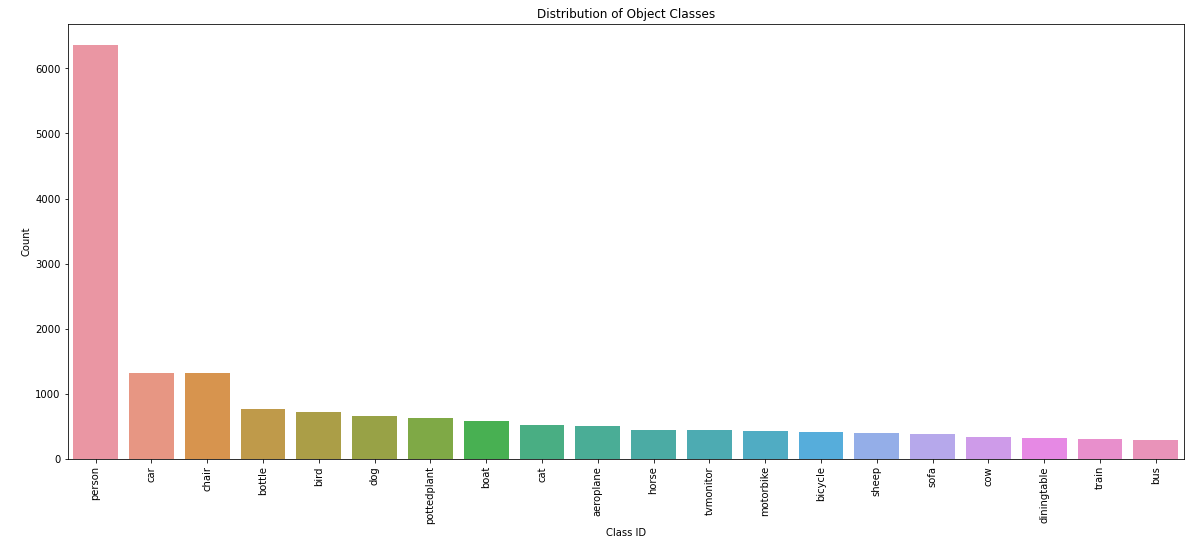
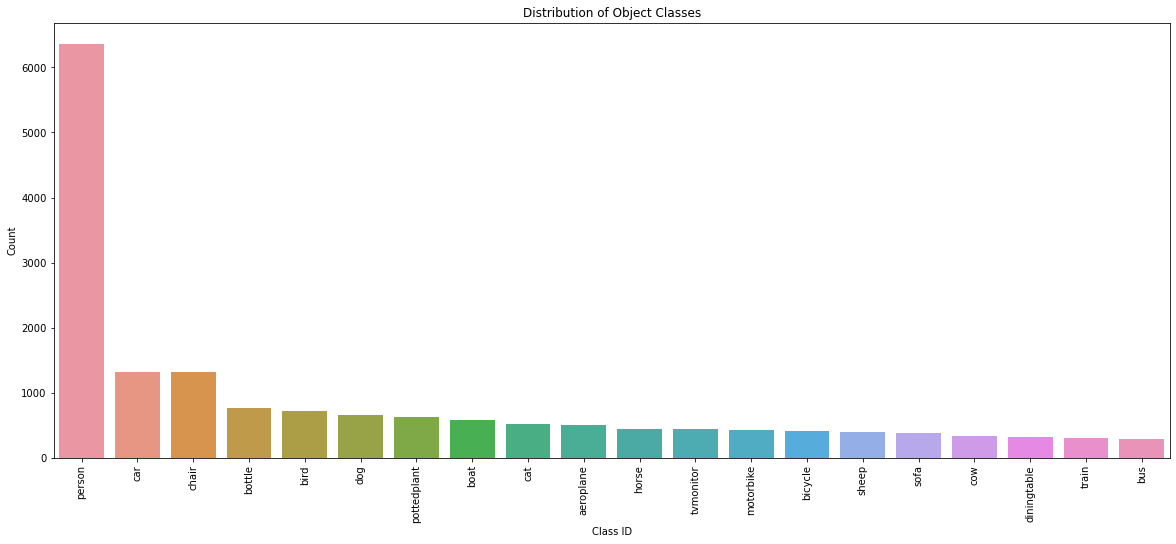

Looking at the pixel distribution size, the images are overall smaller than COCO with the max size being 500x500. The vast majority of images have a height or width of 500 with few images having smaller dimensions. This dataset would be great for proof-of-concept as the image sizes and categories are far less than COCO, making training far simpler. 

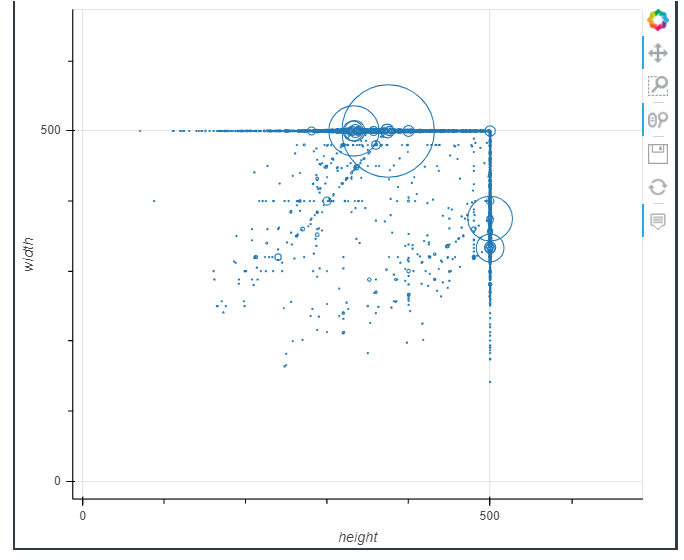
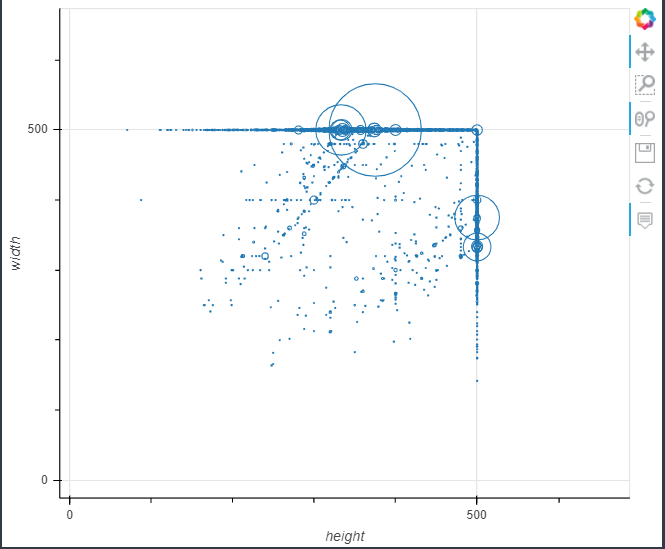

# Models
Sources used: https://github.com/tianzhi0549/FCOS, https://github.com/VectXmy/FCOS.Pytorch, https://github.com/uvipen/Yolo-v2-pytorc

#### YOLOv2

Our implementation of YOLOv2 was not the YOLO9000 version due to our resource limitations. The model has 22 convolutional layers and a residual connection. The predictions are made using the final convolutional layer. The baseline parameters used during training were:

Optimizer = Stochastic Gradient Descent

Epochs = 50

Learning Rate = 1e-5

Decay = 5e-5

Dropout = 0.5

Batch Size = 10

Momentum = 0.9

#### FCOS

For our other object detection models, we decided to use FCOS for its speed and competitiveness with YOLOv2. For our backbone model, we use ResNet 50, however, we “cut off” the end of the network so we are left with block 5 as our last layer (or layer 4 if using pre-trained PyTorch code). The heads of the network are kept the same as the literature. The model parameters are as follows:

Optimizer = Adam

Epochs = 20

Initial Learning Rate = 5e-5

Ending Learning Rate = 1e-6

Cosine Learning Rate Decay

The backbone network before the feature pyramid layers are frozen, as well as batch normalization. Initially, we tried a version of FCOS with batch normalization and achieved sub-optimal results. Since our batch size was quite small (6), we opted for group normalization.

# Results

### YOLOv2

In the results for YOLOv2 we will be looking at the base mode. The model which used ResNet as a backbone was underwhelming and struggled to detect any object. The model which used the non-local block performed decently but did not perform as well as the base. We were not able to perform quantitative analysis, but by looking at images we can see where the model is suceeding and failing.

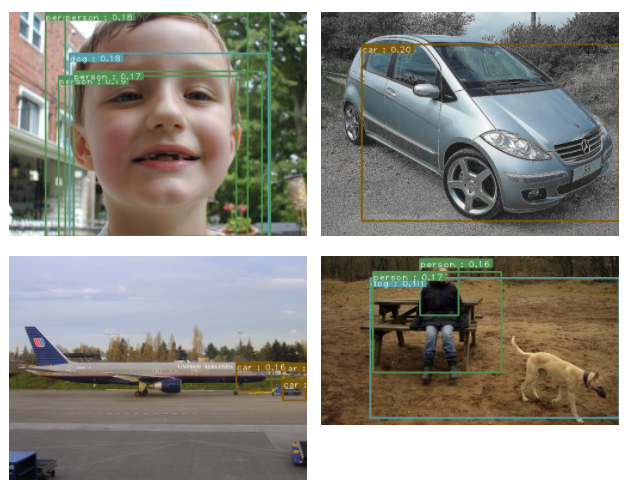

To get detections we had to lower the confidence threshold to quite low levels, in this case it was set to 0.15. The non maximal threshold was left at 0.5. This makes some of the above results suprising. If we look at the child in the top left image we see that there are multiple bounding boxes predicting person (and one predicting dog). One would assume that non maximal supression would deal with this oerlap. The image in the top right is a fairly decent detection. We believe that with more training the class prediction would be more confident, and the box would cover more of the car. The bottom left image demonstrates some of the failure of our model. There is clearly a plane in the center of the image, but our model predicts two cars off to the right. The bottom right image is another example where non maximal supression does not perform how we intended it too. We can also observe that the dog bounding box is far larger then the dog itself. Overall, we were more successfull in our next model, FCOS, where we were actually able to get quantitative results.

One benefit of YOLOv2 was its speed. The training was quite fast, 50 epochs took about four hours. Additionally, depending on the size of the image, it took from 30 to 80 milliseconds to process an image and create bounding boxes. That is a frame rate of 20fps. These results are encouraging because if the detection quality was increased it would make for a fast tracker.

### FCOS

For out results, we consider the "base" version of FCOS in the paper which uses ResNet 50 as a backbone. Results for testing other architectures and features will be found in the ablation section of our project. Code to produce these results can can be found in FCOS/FCOS.Pytorch/model/Base FCOS.ipynb, and the results were aggregated outside of Python into a table for better readability. All of the following numeric charts and tables can be found in our notebook "Data Aggregation".

Our basline model obtained a mAP of 0.501, which is by far the best compared to our other models. To get a better idea of where our model struggles, we examined the average precision by class (below).

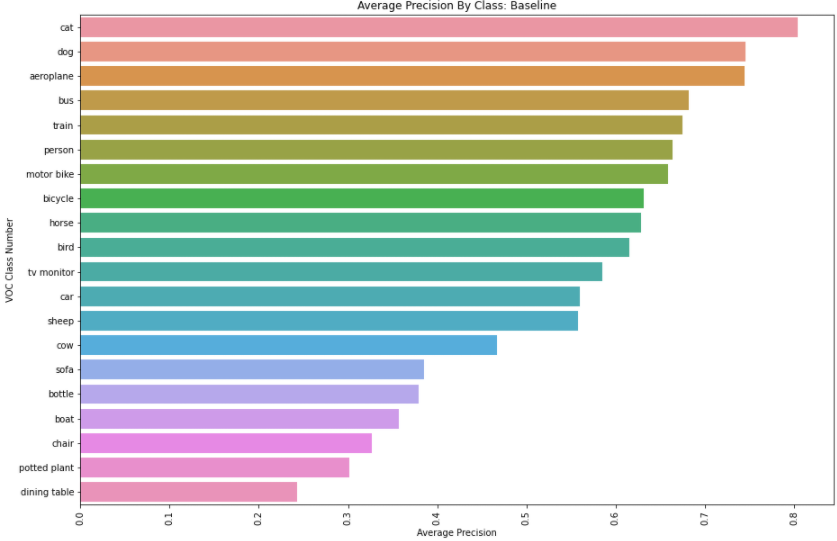


Interestingly, while VOC is vastly made up of the class "person" we see that person is not the most easily identifiable class. While we acknowledge greater frequency does not necessarily mean better accuracy, we did expect some correlation. Compared to our class frequencies in our exploratory data analysis, this would suggest that little correlation exists between class frequency and performance. We suspect that feature structure is far more important than frequency and with enough passes through the data, these differences can be sufficiently learned. To get a better understanding of how precise our model is, we evaluated on validation set of VOC at different IoU thresholds and produced the following chart:

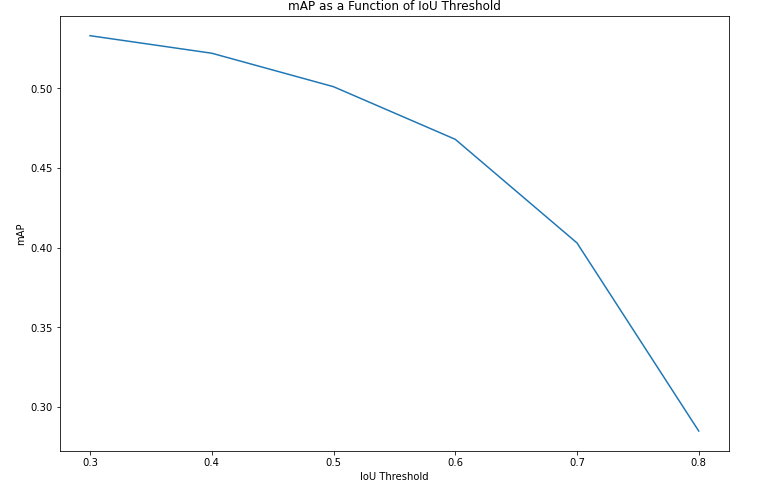

From this chart we see that if we were to take an "elbow analysis" approach, we would be looking at using an IoU threshold of 0.5 or 0.6. Lower thresholds offer diminishing returns while higher thresholds decrease mAP very quickly. In other words, we can get more true positive for a slight trade off in mean average precision. For qualitative results we provide the following images we pulled at random (Generated from previously mentioned Base FCOS notebook).

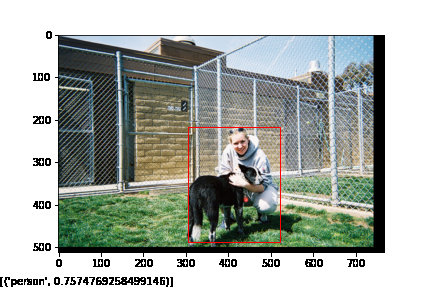

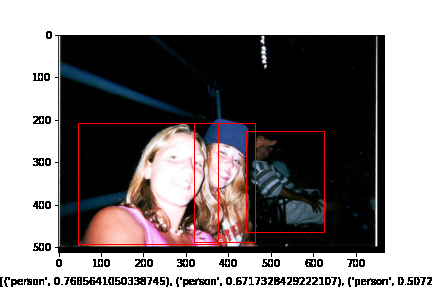

From these two images, we see that our model still captures people well (as suggested by the class AP), even with drastically different lighting. We do see that the model does exhibit lower confidence with the person in the dark background (confidence score of 0.5), suggesting that we could possibly perform data augmentation to change lighting conditions. While we think this process would be overkill for our detector and other augmentation could be used to further improve results, we have seen a GAN (https://arxiv.org/ftp/arxiv/papers/1811/1811.06604.pdf) that can accomplish such a task. However, the model fails to pick up the dog in the first image, suggesting that maybe we the model is missing some objects that overlap.

Code to generate the video can be found in /SORT/sort/FCOS_Pytorch/Code to generate the video can be found in /SORT/sort/FCOS_Pytorch/## SORT

While the main goal of our project was to build object detection models, we wanted to test them qualitatively with object tracking using SORT. For this test we used FCOS with the ResNet-50 backbone. A screen capture can be seen below, but we have provided a link to the video below and included another example in our demo folder. While we are are not tracking every object we should be, overall our detections and tracking perform quite well.

Link to tracking video: https://imgur.com/y10PauY

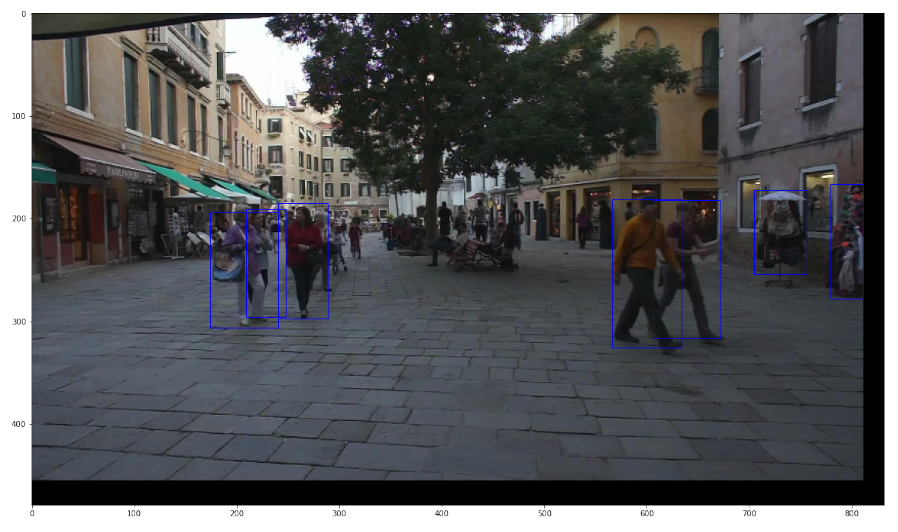

Code to generate the video can be found in /SORT/sort/FCOS_Pytorch/

# Ablation Studies and Additional Experiments

After looking at out baseline results we performed ablation studies. These included the following:

1. Adding a Non Local Block to the baseline model
2. Changing the backbone network from ResNet 50 to ShuffleNet v2
3. Changing the backbone network from ResNet50 to MobileNet v2
4. Addition of a non-local block in the backbone network
5. Addition of a non-local block into the FCOS detection heads
6. Removal of centerness
7. Addition of a non-local block to YOLOv2

It should be noted that 3, 4, 5, and 6 above are performed with MobileNet v2 as the results from 2 were comparable (although slightly worse) to ResNet but the training time was significantly faster. We will also provide hypotheses for why we believe these attempts did or did not work. Below is a high-level summary of the mean average precision for each change.

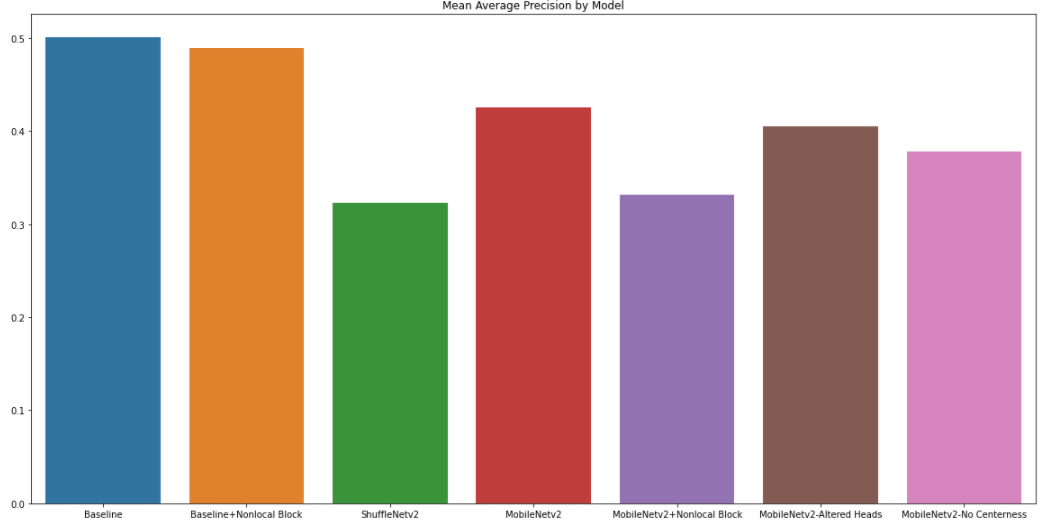


#### Baseline+Nonlocal Block
For change number 1, we added a non-local block right after the 4th block of ResNet-50. The original paper found that this placement worked best in providing a ~1% increase in top-1 and top-5 classification accuracy on ImageNet. Furthermore, we saw this placement as having the added beenfit of being in the middle of the feature pyramid network, thus this information could be propogated to other layers of the feature pyramid. While the Non-Local Networks paper also test their block on object detection tasks, we thought this was a sensible place to start as to minimize additional parameters and training time and progressively see if this change would improve results. Later, we will briefly touch on our attempt to include additional non-local blocks in our network heads similar to what the authors in Non-Local Networks did for their experiments on object detection. While we expected to see a small increase in performance what we saw was actually the opposite. We think there are two reasons to explain this:

1. One local block simply does not introduce enough parameters or information to make a meaningful difference.
2. Our detector is anchor free and is not restricted to the size, scale, and aspect ratio of the boxes. Thus, our network is already inherently better at capturing non-local information as we are not limited to these local regions.

#### ShuffleNetv2

Our second change was changing the backbone network to ShuffleNetv2. The motivation behind switching the backbone to ShuffleNetv2 was for it's state-of-the-art performance on ImageNet while being incredibly fast, especially at evaluation time. This change was actually our worst, with a mean average precision of just over 0.3. We place our feature pyramid network layers to maintain the same strides (8, 16, 32) obtained from downsampling in the network. The images below display the architectures for ShuffleNet v2 and ResNet50 for reference. We think the poor performance of ShuffleNet v2 is caused by the ratio of feature maps (i.e. depth) to downsampling. When placing the feature pyramid map layers at after stages 2, 3, and 4 we believe that ShuffleNetv2 does not have the opportunity to be sufficiently deep or wide at the early layers given the amount of downsampling. On the other hand ResNet-50 already is much wider/deeper when placing the first connection to the feature pyramid after conv3_x given the same stride. To test whether this hypothesis is true, we searched for a pre-trained version of ShuffleNetv2 1.5x and ShuffleNetv2 in an attempt to increase the width of the network, however, PyTorch only has 0.5x and 1.0x pre-trained versions available. Additional searches on github were also unsuccessful.

ShuffleNetv2

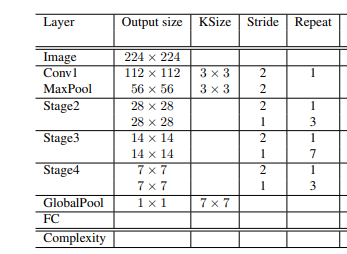

ResNet-50

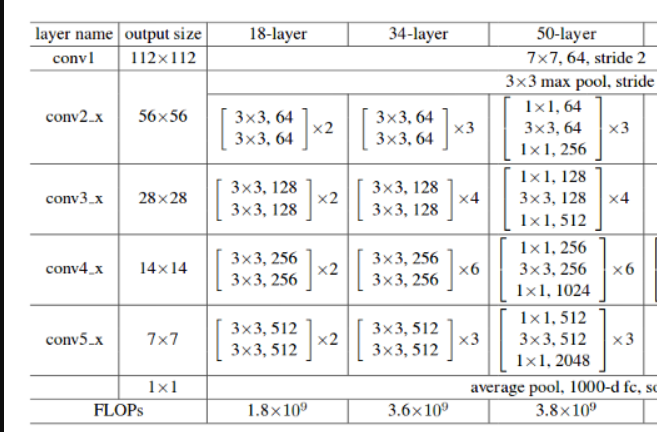

#### MobileNetv2
Training with ResNet50, although successful, is extremely "expensive" given our GPU resources. After the less than ideal results from ShuffleNetv2 we still wanted to explore another small network, which is where MobileNetv2 comes in. Recall the architecture for MobileNet v2:

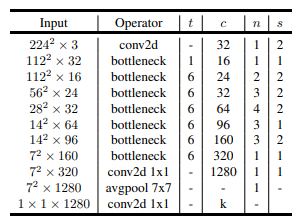

We found MobileNet v2 to strike a perfect balance between resource usage and mean average precision. Our mean average precision was 0.426, roughly 7 points lower than our baseline. While not ideal, this model could still produce some decent detections. We believe the success of MobileNetv2 over ShuffleNet v2 is due to the reason discussed earlier--the network is deeper/wider given the first placement of our feature pyramid map which occurs at stride 8. In the image above, this would be at input $28^2$ where we have a 2D convolution and two bottlenecks, excluding the bottleneck at the input of $28^2$ itself. For this reason, we believe this provides further evidence for there needing to be sufficient depth/width before substantial downsampling in order to achieve better performance.

#### MobileNetv2 with a non-local block

Despite the slightly worse performance of ResNet-50, we still wanted to analyze the impact of a non-local block into MobileNet v2. Just as with ResNet-50, we place the non-local block after the input layer in which stride 16 is obtained and use the resulting feature maps as the center of our feature pyramid network. Here, we see our performance decrease substantially moreso than with ResNet50. Since our network contains far less parameters than our ResNet-50 backbone, it makes sense that this change is more sensitive when applying it to MobileNet v2. However, it is still somewhat unclear why such a change is causing such a drastic decrease in performance. Again we think that since our detector is not limited by anchor boxes this architecture does not provide us benefit. 

#### MobileNetv2 with altered heads

In the FCOS architecture (which can be seen in the literature review), there are four convolutions on each the classification and regression branches of the detector heads. In the paper for FCOS, they tested their results on MS COCO which is substantially larger than VOC and contains more classes. For this reason, we wanted to see if we could get away with reducing the parameters in the branches while obtaining similar performance. We removed two convolutional layers from both the classification and regression branches. We know that convolutions are cheap, but still wanted to explore the idea of where we could trim unnecessary parameters. This change led to a relatively small decrease in mAP from 0.426 to 0.405. This suggests that there are possibly ways to make these layers more efficient through some modification. One change we did not test, but think would lead to nearly identical results would be using depthwise group convolutions to further increase the efficiency of the network.

#### MobileNetv2 with centerness turned off

To evaluate the effectiveness of the centerness, we disable it by making the loss zero so the network will not train on this loss. To quickly recap the centerness feature: the centerness branch is used to supress low quality bounding boxes by measuring the distance of the regression targets to the center of the object. We know disabling this centerness feature will decrease our mAP but we wanted to answer the question of how much. After implementing this modification, we see a substantial decrease in performance. Mean average precision decreases by roughly 0.05 suggesting that the centerness feature is an integral part of the network in obtaining state-of-the-art performance. 


#### Non-Local block in detection heads (not pictured)

To explore the author's use of non-local blocks in the Non Local Networks paper for object detection, we attempted to include non local blocks in the FCOS detection heads. Ultimately, this method resulted in an unstable model and was unsuccessful. More details are presented in the next section.